# Cloverleaf Bridge

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Dataset and Preprocessing

Downloaded image has been saved to `images/cloverleaf_interchange.png`

### Image Loading and Exploration

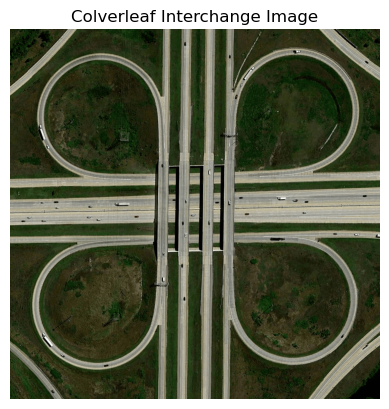

In [187]:
def load_cloverleaf_image():
    img = cv2.imread('images/cloverleaf_interchange.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # covnert to RGB
    return img

img = load_cloverleaf_image()
plt.imshow(img)
plt.axis('off')
plt.title("Colverleaf Interchange Image")
plt.show()

In [188]:
# print basic image information
print("Image Height:", img.shape[0])
print("Image Width:", img.shape[1])
print("Number of Channels:", img.shape[2])
print("Pixel Value Range:", np.min(img),'to', np.max(img))
print("Data Type:", img.dtype)

Image Height: 1207
Image Width: 1207
Number of Channels: 3
Pixel Value Range: 0 to 253
Data Type: uint8


In [189]:
def plot_histogram(r, g, b, pooled, title):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    ax[0].plot(range(256), r, color='red')
    ax[0].set_title("Red Channel Histogram")
    ax[0].set_xlabel("Pixel Value")
    ax[0].set_ylabel("Frequency")
    ax[1].plot(range(256), g, color='green')
    ax[1].set_title("Green Channel Histogram")
    ax[1].set_xlabel("Pixel Value")
    ax[1].set_ylabel("Frequency")
    ax[2].plot(range(256), b, color='blue')
    ax[2].set_title("Blue Channel Histogram")
    ax[2].set_xlabel("Pixel Value")
    ax[2].set_ylabel("Frequency")
    ax[3].plot(range(256), pooled, color='gray')
    ax[3].set_title("Pooled Histogram")
    ax[3].set_xlabel("Pixel Value")
    ax[3].set_ylabel("Frequency")
    
    plt.suptitle(title)
    plt.show()

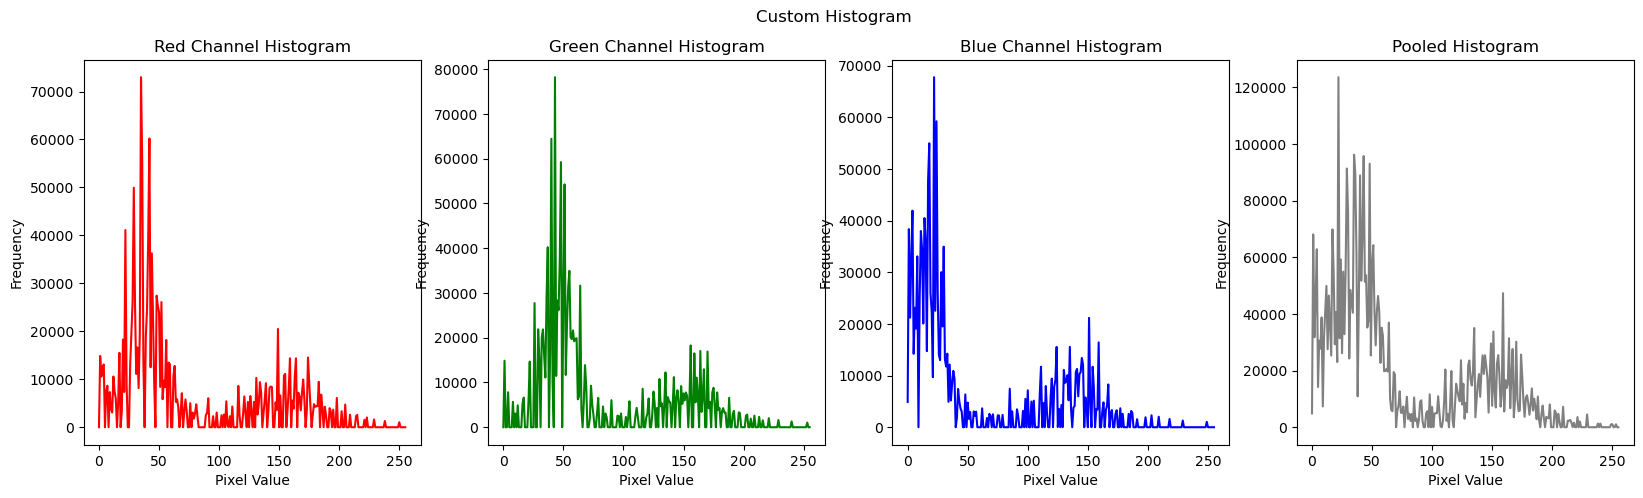

In [190]:
# custom histogram function
r, g, b = cv2.split(img)
freq_r = [0 for _ in range(256)]
freq_g = [0 for _ in range(256)]
freq_b = [0 for _ in range(256)]
for i in r.flatten():
    freq_r[i] += 1
for i in g.flatten():
    freq_g[i] += 1
for i in b.flatten():
    freq_b[i] += 1
freq_pooled = [freq_r[i] + freq_g[i] + freq_b[i] for i in range(256)]
plot_histogram(freq_r, freq_g, freq_b, freq_pooled, "Custom Histogram")

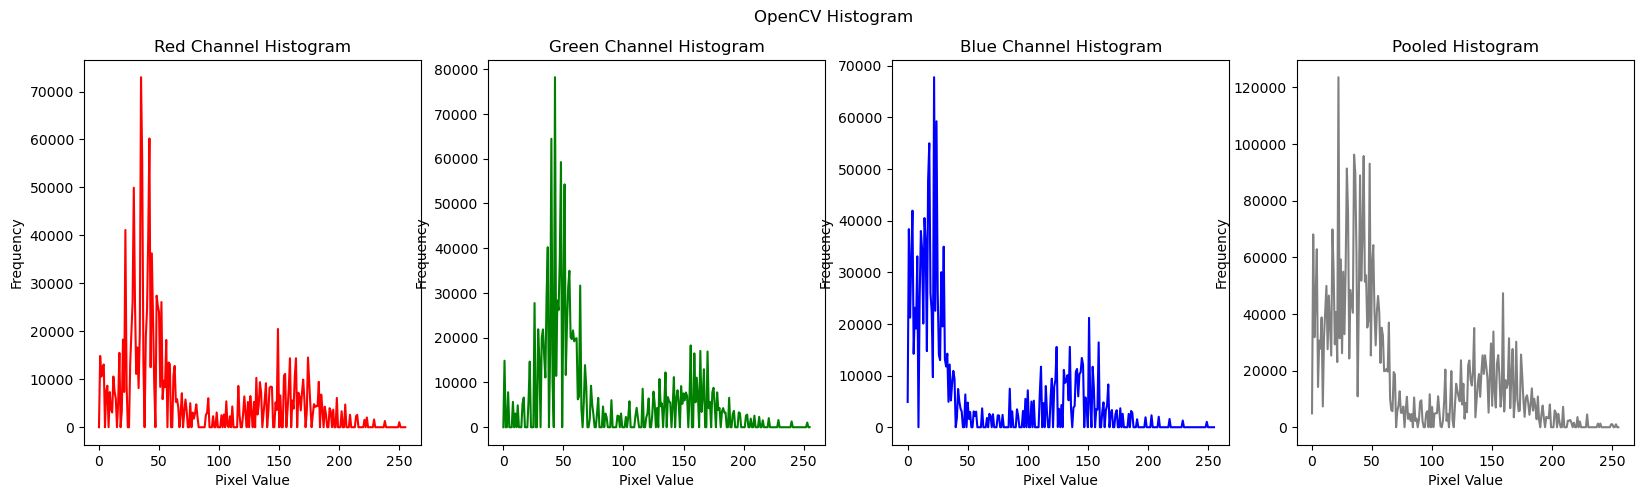

In [191]:
# opencv histogram
r_hist = cv2.calcHist([img], [0], None, [256], [0, 256])
g_hist = cv2.calcHist([img], [1], None, [256], [0, 256])
b_hist = cv2.calcHist([img], [2], None, [256], [0, 256])
pooled_hist = r_hist + g_hist + b_hist
plot_histogram(r_hist, g_hist, b_hist, pooled_hist, "OpenCV Histogram")


### Image Preprocessing

In [192]:
def preprocess_image(image, kernel_size=5, sigma=1):
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (kernel_size, kernel_size), sigma)
    img_thresh = cv2.threshold(img_blur, 90, 255, cv2.THRESH_BINARY)[1]
    return img_thresh

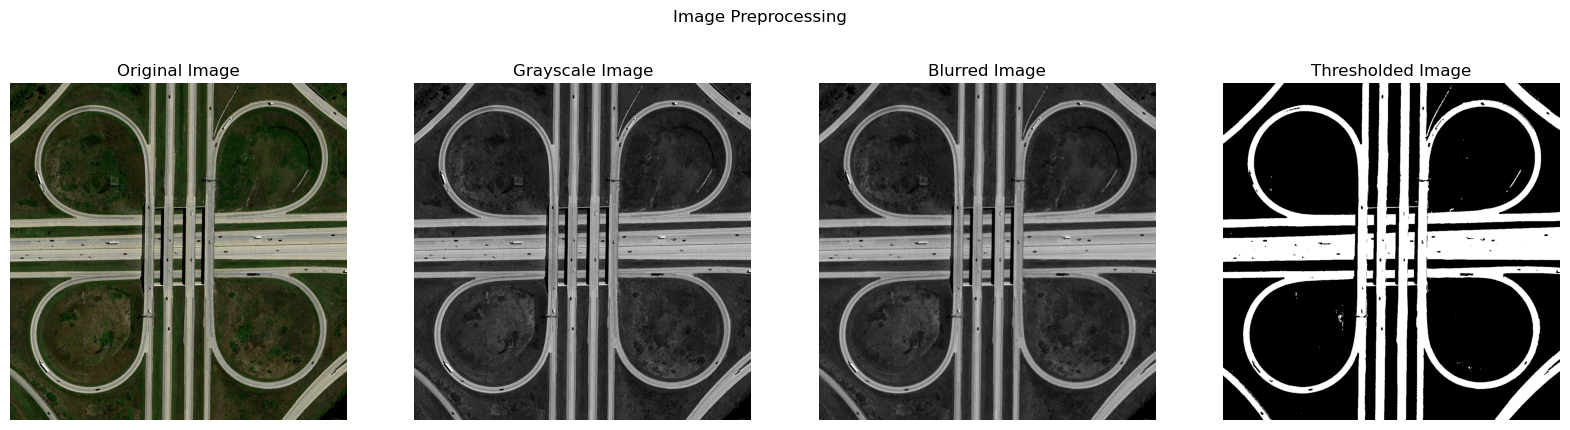

In [193]:
# showing intermediate steps in image preprocessing
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (5, 5), 1)
img_thresh = cv2.threshold(img_blur, 90, 255, cv2.THRESH_BINARY)[1]
img_thresh_without_blur = cv2.threshold(img_gray, 90, 255, cv2.THRESH_BINARY)[1]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(img_gray, cmap='gray')
ax[1].set_title("Grayscale Image")
ax[1].axis('off')
ax[2].imshow(img_blur, cmap='gray')
ax[2].set_title("Blurred Image")
ax[2].axis('off')
ax[3].imshow(img_thresh, cmap='gray')
ax[3].set_title("Thresholded Image")
ax[3].axis('off')
plt.suptitle("Image Preprocessing")
plt.show()

#### Preprocessing Steps

The image is converted to grayscale as it simplifies the image by reducing it to a single channel. This is needed as Hough Transform for circle detection works on edge information which is easily computed from single channel images.

Gaussian Blur helps to remove the noise from the image which helps in reducing the number of false edges detected by the edge detection algorithm part of the Hough Transform. 

Thresholding is used to convert the grayscale image to a binary image. This is done to filter out the noise which retaining the significant edges in the image.

## Cloverleaf Detection and Measurement

### Cloverleaf Detection and Visualization

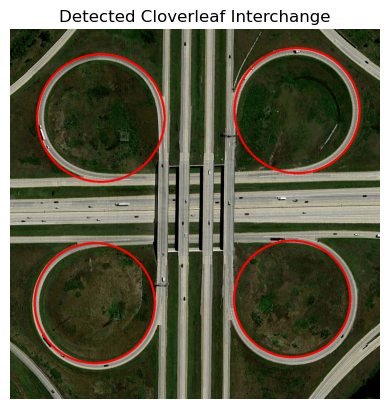

In [194]:
def detect_cloverleaves(img, min_dist=None, param1=None, param2=None):
    param1 = 80 if param1 is None else param1
    param2 = 30 if param2 is None else param2
    min_dist = 80 if min_dist is None else min_dist
        
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp=1, minDist=min_dist, param1=param1, param2=param2, minRadius=180, maxRadius=250)
    return circles

def circles_on_image(img, circles):
    img_circles = img.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(img_circles, (i[0], i[1]), i[2], (255, 0, 0), 5)
    return img_circles

preprocessed_img = preprocess_image(img)
detected_circles = detect_cloverleaves(preprocessed_img)
img_circles = circles_on_image(img, detected_circles)

# detected cloverleaf circles on the image
plt.imshow(img_circles)
plt.axis('off')
plt.title("Detected Cloverleaf Interchange")
plt.show()
    

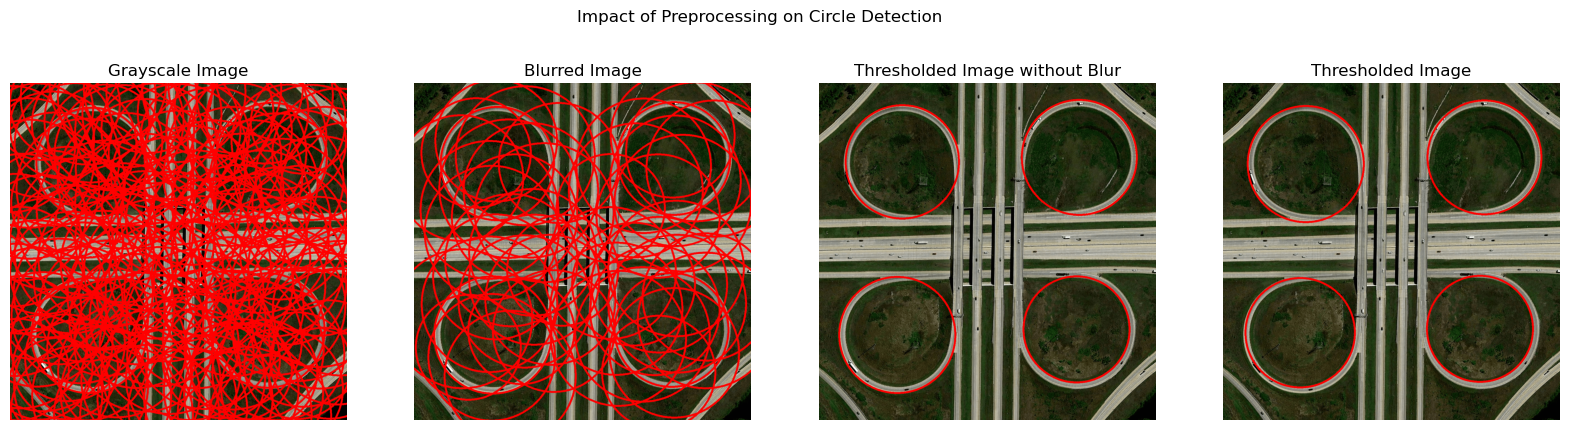

In [195]:
# impact of preprocessing on circle detection
preprocessed_imgs = [img_gray, img_blur, img_thresh_without_blur, img_thresh]
titles = ["Grayscale Image", "Blurred Image", "Thresholded Image without Blur", "Thresholded Image"]
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    detected_circles = detect_cloverleaves(preprocessed_imgs[i])
    img_circles = circles_on_image(img, detected_circles)
    ax[i].imshow(img_circles)
    ax[i].set_title(titles[i])
    ax[i].axis('off')
    
plt.suptitle("Impact of Preprocessing on Circle Detection")
plt.show()

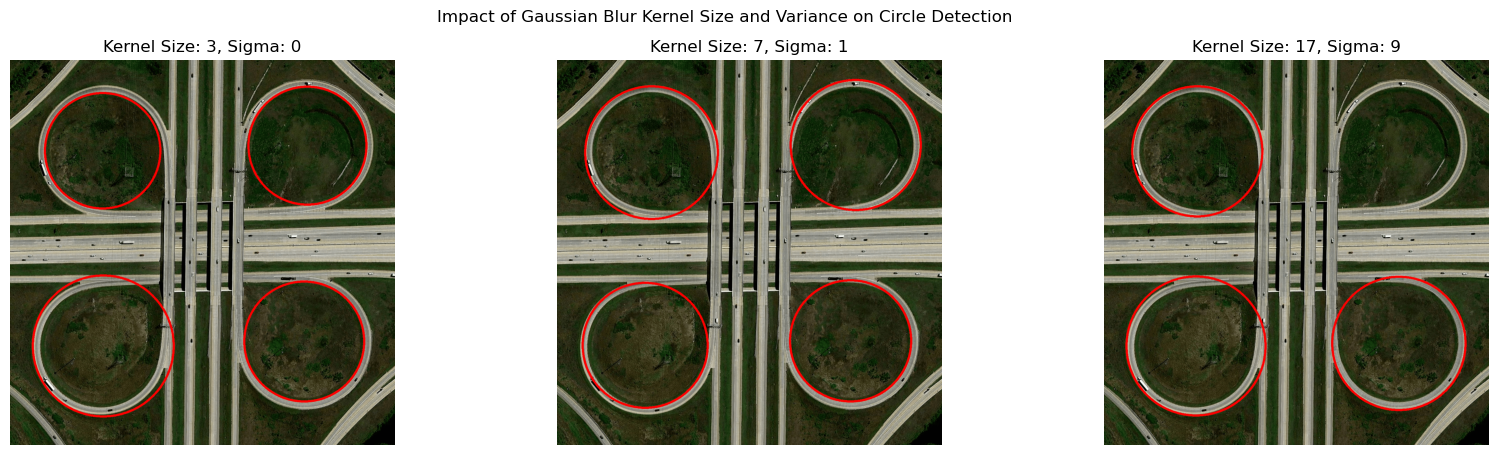

In [196]:
# impact of gaussin blur kernel size and variance on circle detection
kernel_sizes = [3, 7, 17]
sigmas = [0, 1, 9]
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i in range(3):
    preprocessed_img = preprocess_image(img, kernel_size=kernel_sizes[i], sigma=sigmas[i])
    detected_circles = detect_cloverleaves(preprocessed_img)
    img_circles = circles_on_image(img, detected_circles)
    ax[i].imshow(img_circles)
    ax[i].set_title(f"Kernel Size: {kernel_sizes[i]}, Sigma: {sigmas[i]}")
    ax[i].axis('off')
        
plt.suptitle("Impact of Gaussian Blur Kernel Size and Variance on Circle Detection")
plt.show()

#### Impact of Preprocessing Steps
Detecting circles on only the grayscale image results in a lot of false positives. This is because the edge detection algorithm is sensitive to noise and the image has a lot of noise. Adding Gaussian Blur reduces the noise in the image and results in a better edge detection. Thresholding further reduces the noise and retains the significant edges in the image. Thresholding is the most important step in this process while Blurring is optional.

#### Impact of Gaussian Blur
Increasing the kernel radius and sigma of the Gaussian Blur increases the amount of blurring in the image. This results in a smoother image with less noise. This helps in reducing the number of false positives in the edge detection algorithm. However, too much blurring can result in loss of significant edges in the image.

#### Parameter Choices
The parameters for the Hough Circle Transform are chosen based on the image size and the size of the circles in the image. 
- `dp=1` as the accumulator resolution is the same as the image resolution.
- `minDist=80` to prevent multiple circles from being detected for the same circle.
- `param1=80` which denotes the edge detection threshold for the Canny edge detector.
- `param2=30` which denotes the accumulator threshold for the circle centers at the detection stage.
- `minRadius=250` and `maxRadius=320` based on the image dimensions. Given width of 1200 pixels, and the radius of the circle is around and less than 300 pixels, the range is chosen to be around 250 to 320. 

#### Challenges in detecting cloverleaf circles
- The cloverleaf circles are not perfect circles. They are distorted due to the perspective of the image and the shape is almost 3/4th of a circle. This makes it difficult to detect the circles using the Hough Circle Transform. This requires tuning the parameters of the Hough Circle Transform to detect the distorted circles.
- The concentric circles for the two sides of each road lead to multiple circles being detected for the same road. This requires tuning the `minDist` parameter to prevent multiple circles from being detected for the same road.

#### Failue Cases
- The implemented solution has the parameters adjusted as per the given image. This may not work for other images of cloverleaf interchanges. The parameters need to be adjusted based on the size of the circles in the image.
- The Hough Circle Transform is sensitive to noise and the image has a lot of noise. This may result in false positives in the circle detection. This can be reduced by further preprocessing the image to reduce the noise.
- Partially occluded circles may not be accurately detected by the Hough Circle Transform.

### Measuring the Radii of the Detected Cloverleaves

In [197]:
def calculate_radii(img):
    preprocessed_img = preprocess_image(img)
    detected_circles = detect_cloverleaves(preprocessed_img)
    if detected_circles is None:
        return None
    radii = np.uint16(np.around(detected_circles[0, :, 2]))
    return radii

radii = calculate_radii(img)
print("Estimated Radii:", *radii if radii is not None else "None", "px")

Estimated Radii: 204 208 190 196 px


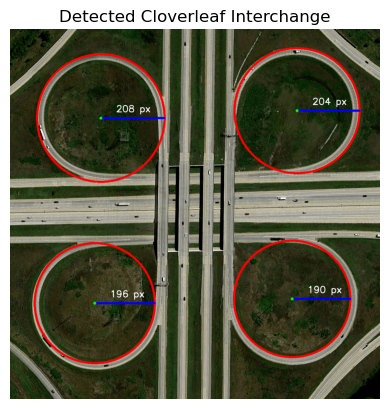

In [198]:
def detailed_circles_on_image(img, circles):
    img_circles = img.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # circle outline
            cv2.circle(img_circles, (i[0], i[1]), i[2], (255, 0, 0), 5)
            # circle radius
            # draw radii lines
            cv2.line(img_circles, (i[0], i[1]), (i[0] + i[2], i[1]), (0, 0, 255), 5)
            cv2.putText(img_circles, str(i[2]) + " px", (i[0] + 50, i[1] - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            # center of the circle
            cv2.circle(img_circles, (i[0], i[1]), 2, (0, 255, 0), 5)
    return img_circles

preprocessed_img = preprocess_image(img)
detected_circles = detect_cloverleaves(preprocessed_img)
img_circles = detailed_circles_on_image(img, detected_circles)

plt.imshow(img_circles)
plt.axis('off')
plt.title("Detected Cloverleaf Interchange")
plt.show()

#### How is the radius measured?
The Hough Circle Transform uses a 3D parametric space to represent all possible cirlces in the image. Two of the dimensions are for the x,y coordinates of the center of the circle and the third dimension is for the radius of the circle. The accumulator array is used to store the votes for each possible circle in the image. The circle with the maximum votes is chosen as the detected circle. The radius of the detected circle is the radius of the cloverleaf circle.

#### Assumptions made
- The cloverleaf circles are almost 3/4th of a circle. This is assumed to be a perfect circle for the purpose of this problem.
- The radius of the detected circle is the radius of the cloverleaf circle.

#### Potential Sources of Error
- The Hough Circle Transform is sensitive to noise and the image has a lot of noise. This may result in false positives in the circle detection. This can be reduced by further preprocessing the image to reduce the noise.
- Partially occluded circles may not be accurately detected by the Hough Circle Transform.

### Approximating the Area Enclosed by Each Cloverleaf

In [199]:
# Assuming perfect circle
def calculate_area_1(img):
    radii = calculate_radii(img)
    if radii is None:
        return None
    areas = [np.pi * r**2 for r in radii]
    return areas

# Assuming 3/4 circle + square of side length equal to radius of circle
def calculate_area_2(img):
    radii = calculate_radii(img)
    if radii is None:
        return None
    areas = [3/4 * np.pi * r**2 + r**2 for r in radii]
    return areas

areas_1 = calculate_area_1(img)
areas_2 = calculate_area_2(img)

print("Estimated Areas (Assuming Perfect Circle):")
print("\n".join(f"{area} sq px" for area in areas_1))
print()
print("Estimated Areas (Assuming 3/4 Circle + Square):")
print("\n".join(f"{area} sq px" for area in areas_2))
print()

Estimated Areas (Assuming Perfect Circle):
130740.51987179283 sq px
135917.8645649088 sq px
113411.49479459153 sq px
120687.4233803055 sq px

Estimated Areas (Assuming 3/4 Circle + Square):
139671.38990384463 sq px
145202.39842368162 sq px
121158.62109594364 sq px
128931.56753522911 sq px



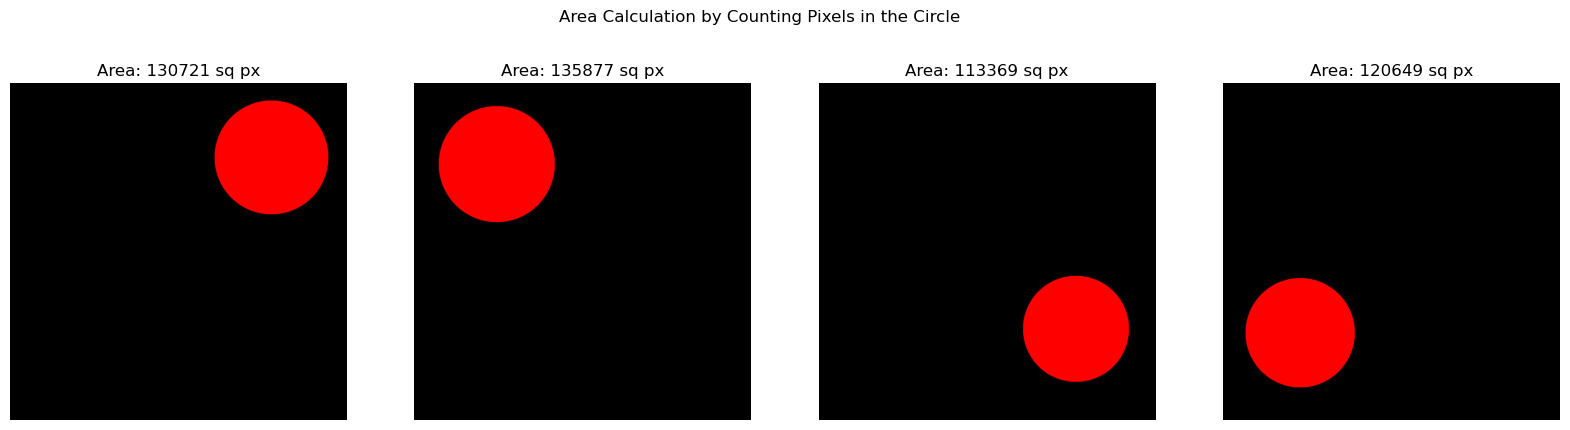

Estimated Areas (Counting Pixels in the Circle):
130721 sq px
135877 sq px
113369 sq px
120649 sq px



In [200]:
# calculating area by counting pixels in the circle
def calculate_area_3(img):
    circles = detect_cloverleaves(preprocess_image(img))
    circles = np.uint16(np.around(circles))
    if circles is None:
        return None
    
    # draw circles on a blank image
    masked_images = []
    for i in circles[0, :]:
        blank = np.zeros_like(img)
        cv2.circle(blank, (i[0], i[1]), i[2], (255, 0, 0), -1)
        masked_images.append(blank)
    
    areas = []
    for masked_img in masked_images:
        masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
        areas.append(np.sum(masked_img != 0))
        
    return masked_images, areas

preprocessed_img = preprocess_image(img)
detected_circles = detect_cloverleaves(preprocessed_img)
masked_images, areas_3 = calculate_area_3(img)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax[i].imshow(masked_images[i], cmap='gray')
    ax[i].set_title(f"Area: {areas_3[i]} sq px")
    ax[i].axis('off')
    
plt.suptitle("Area Calculation by Counting Pixels in the Circle")
plt.show()

print("Estimated Areas (Counting Pixels in the Circle):")
print("\n".join(f"{area} sq px" for area in areas_3))
print()

##### Comparison of Area Calculation Methods

3 methods are used to calculate the area enclosed by the cloverleaf circles:
1. Using the radius of the detected circle to calculate the area of the circle.
2. Estimate the area of the cloverleaf circle by approximating it as a 3/4th circle + square of side length equal to the radius of the circle.
3. Create a mask of the detected circle and calculate the area enclosed by the mask.
   
| Method | Area 1 (sq. pixels) | Area 2 (sq. pixels) | Area 3 (sq. pixels) | Area 4 (sq. pixels) |
|--------|----------------------|----------------------|----------------------|----------------------|
| Circle | 130740.5198         | 135917.8645            | 113411.4947        | 120687.4233    |
| 3/4 Circle + Square | 139671.3899 | 145202.3984 | 121158.6210 | 128931.5675 |
| Circluar Mask |  130721 |135877 |113369 |120649 |

Observations:
- The area calculated using the circular mask is similar to the area calculated using the radius of the detected circle.
- The area calculated using the 3/4 circle + square approximation is the most accurate as it approximates the shape of the cloverleaf circle.